# Additional Analysis: Article Fact Vector Analysis

Investigates the fact vectors generated by GPT 3.5 and GPT 4 models. This is an additional analysis performed outside of the scope of my original KaggleX BIPOC mentorship project.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fact-checking-gpt-small/veracity.pkl


In [2]:
# Additional imports
import pickle
from collections import Counter, defaultdict

# From scikit learn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [3]:
# Data set
veracity = pd.read_pickle('/kaggle/input/fact-checking-gpt-small/veracity.pkl')

# Check
veracity.head()

,label,fact_count,gpt4_veracity_vector,gpt4_true_count,gpt4_false_count,gpt4_undetermined_count,gpt4_incomplete_count,gpt4_true_pct,gpt4_false_pct,gpt4_undetermined_pct,gpt4_incomplete_pct,gpt35_veracity_vector,gpt35_true_count,gpt35_false_count,gpt35_undetermined_count,gpt35_incomplete_count,gpt35_true_pct,gpt35_false_pct,gpt35_undetermined_pct,gpt35_incomplete_pct
0,true,12,"[True, True, True, Undetermined, Undetermined,...",8,1,2,1,0.666667,0.083333,0.166667,0.083333,"[True, Undetermined, True, Undetermined, Undet...",6,0,6,0,0.500000,0.000000,0.500000,0.0
1,fake,7,"[Undetermined, True, False, True, False, False...",3,3,1,0,0.428571,0.428571,0.142857,0.000000,"[Undetermined, True, False, True, False, False...",3,3,1,0,0.428571,0.428571,0.142857,0.0
2,true,7,"[Undetermined, Undetermined, Undetermined, Tru...",1,0,6,0,0.142857,0.000000,0.857143,0.000000,"[Undetermined, Undetermined, Undetermined, Tru...",1,0,6,0,0.142857,0.000000,0.857143,0.0
3,fake,7,"[True, True, True, True, True, True, True]",7,0,0,0,1.000000,0.000000,0.000000,0.000000,"[True, True, True, True, True, True, True]",7,0,0,0,1.000000,0.000000,0.000000,0.0
4,fake,3,"[Undetermined, Undetermined, Undetermined]",0,0,3,0,0.000000,0.000000,1.000000,0.000000,"[Undetermined, Undetermined, Undetermined]",0,0,3,0,0.000000,0.000000,1.000000,0.0


Since this analysis focuses on the veracity vectors, each vector will need to be transformed to a numeric value.

In [4]:
# Veracity map
veracity_map = {'True': 1,
                'False': 2,
                'Undetermined': 3,
                'Incomplete': 4}

In [5]:
# Numeric vectors
gpt4_num_vec = []
gpt35_num_vec = []

# Iterate gpt 4 vectors
for vector in veracity.gpt4_veracity_vector:
    # Update the vector
    gpt4_num_vec.append([veracity_map.get(v) for v in vector])

In [6]:
# Iterate gpt 3.5 vectors
for vector in veracity.gpt35_veracity_vector:
    # Update the vector
    gpt35_num_vec.append([veracity_map.get(v) for v in vector])

Since the vectors will all have different sizes, it's important to determine the range of lengths and then pad each vector accordingly. Padding values will also need special values. Typically, padding is done via 0s, and that will be maintained here.

In [7]:
# Get lengths
gpt35len = [len(v) for v in gpt35_num_vec]

# Find the min and max lens
print('The minimum length is {} and the maximum length is {}.'.format(min(gpt35len), max(gpt35len)))

The minimum length is 0 and the maximum length is 13.


In [8]:
# Get lengths
gpt4len = [len(v) for v in gpt4_num_vec]

# Find the min and max lens
print('The minimum length is {} and the maximum length is {}.'.format(min(gpt4len), max(gpt4len)))

The minimum length is 0 and the maximum length is 16.


In [9]:
# Begin padding
def vectPads(v, max_len):
    '''
    Based on a specified maxed length, pads a vector with 0s.
    '''
    # Creates a numpy array with padding
    v = np.pad(v, (0, max_len - len(v)), 'constant', constant_values = 0)
    # Return the padded array
    return v

In [10]:
# New padded arrays
gpt35_padded = [vectPads(v, max(gpt35len)) for v in gpt35_num_vec]

In [11]:
# GPT 4 padded arrays
gpt4_padded = [vectPads(v, max(gpt4len)) for v in gpt4_num_vec]

## GPT 3.5 Agglomerative Clustering Experiment

In [12]:
# Linkage model parameter list
agg_clust_linkages = ['complete', 'average', 'single']

In [13]:
# Label details
vect_label_dict = defaultdict(np.array)

# Attribute details
attr_df = pd.DataFrame(data={'run_id': [np.nan]*len(agg_clust_linkages), 
                             'linkage': [np.nan]*len(agg_clust_linkages), 
                             'n_clusters': [np.nan]*len(agg_clust_linkages), 
                             'n_leaves': [np.nan]*len(agg_clust_linkages), 
                             'n_connected_components': [np.nan]*len(agg_clust_linkages),
                             'davies_bouldin': [np.nan]*len(agg_clust_linkages),
                             'calinski_harabasz': [np.nan]*len(agg_clust_linkages),
                             'silhouette_score': [np.nan]*len(agg_clust_linkages)})


# Iterate through linkages
for i,link in enumerate(agg_clust_linkages):
    print(f'Begin run {i}, linkage: {link}\n\n')
    # Initialize AgglomerativeClustering
    vect_clustering = AgglomerativeClustering(metric='jaccard', linkage=link)

    # labels
    vect_labels = vect_clustering.fit_predict(gpt35_padded)
    vect_label_dict[i] = vect_labels
    
    # Davies-Bouldin score
    davies_bouldin = davies_bouldin_score(gpt35_padded, vect_labels)
    
    # Calinski-Harabasz score
    calinski_harabasz = calinski_harabasz_score(gpt35_padded, vect_labels)
    
    # Silhouette score
    silhouette = silhouette_score(gpt35_padded, vect_labels, metric='jaccard', random_state=0)
    
    # attributes
    with pd.option_context('mode.chained_assignment', None):
        attr_df.run_id[i] = i
        attr_df.linkage[i] = link
        attr_df.n_clusters[i] = vect_clustering.n_clusters_
        attr_df.n_leaves[i] = vect_clustering.n_leaves_
        attr_df.n_connected_components[i] = vect_clustering.n_connected_components_
        attr_df.davies_bouldin[i] = davies_bouldin
        attr_df.calinski_harabasz[i] = calinski_harabasz
        attr_df.silhouette_score[i] = silhouette
    
    print(f'ATTRIBUTES:')
    print(f'Davies-Bouldin score: {davies_bouldin}')
    print(f'Calinski-Harabasz score: {calinski_harabasz}')
    print(f'Silhouette score: {silhouette}')
    print(f'Cluster count: {vect_clustering.n_clusters_}')
    print(f'Number of leaves: {vect_clustering.n_leaves_}')
    print(f'Connected components: {vect_clustering.n_connected_components_}')
    print('------------------------------------------')

Begin run 0, linkage: complete


ATTRIBUTES:
Davies-Bouldin score: 2.828427918992463
Calinski-Harabasz score: 84.0151982065667
Silhouette score: 0.017913384521801457
Cluster count: 2
Number of leaves: 998
Connected components: 1
------------------------------------------
Begin run 1, linkage: average




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


ATTRIBUTES:
Davies-Bouldin score: 0.7408679304652012
Calinski-Harabasz score: 29.67955783829529
Silhouette score: 0.6811000548153611
Cluster count: 2
Number of leaves: 998
Connected components: 1
------------------------------------------
Begin run 2, linkage: single


ATTRIBUTES:
Davies-Bouldin score: 0.7408679304652012
Calinski-Harabasz score: 29.67955783829529
Silhouette score: 0.6811000548153611
Cluster count: 2
Number of leaves: 998
Connected components: 1
------------------------------------------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


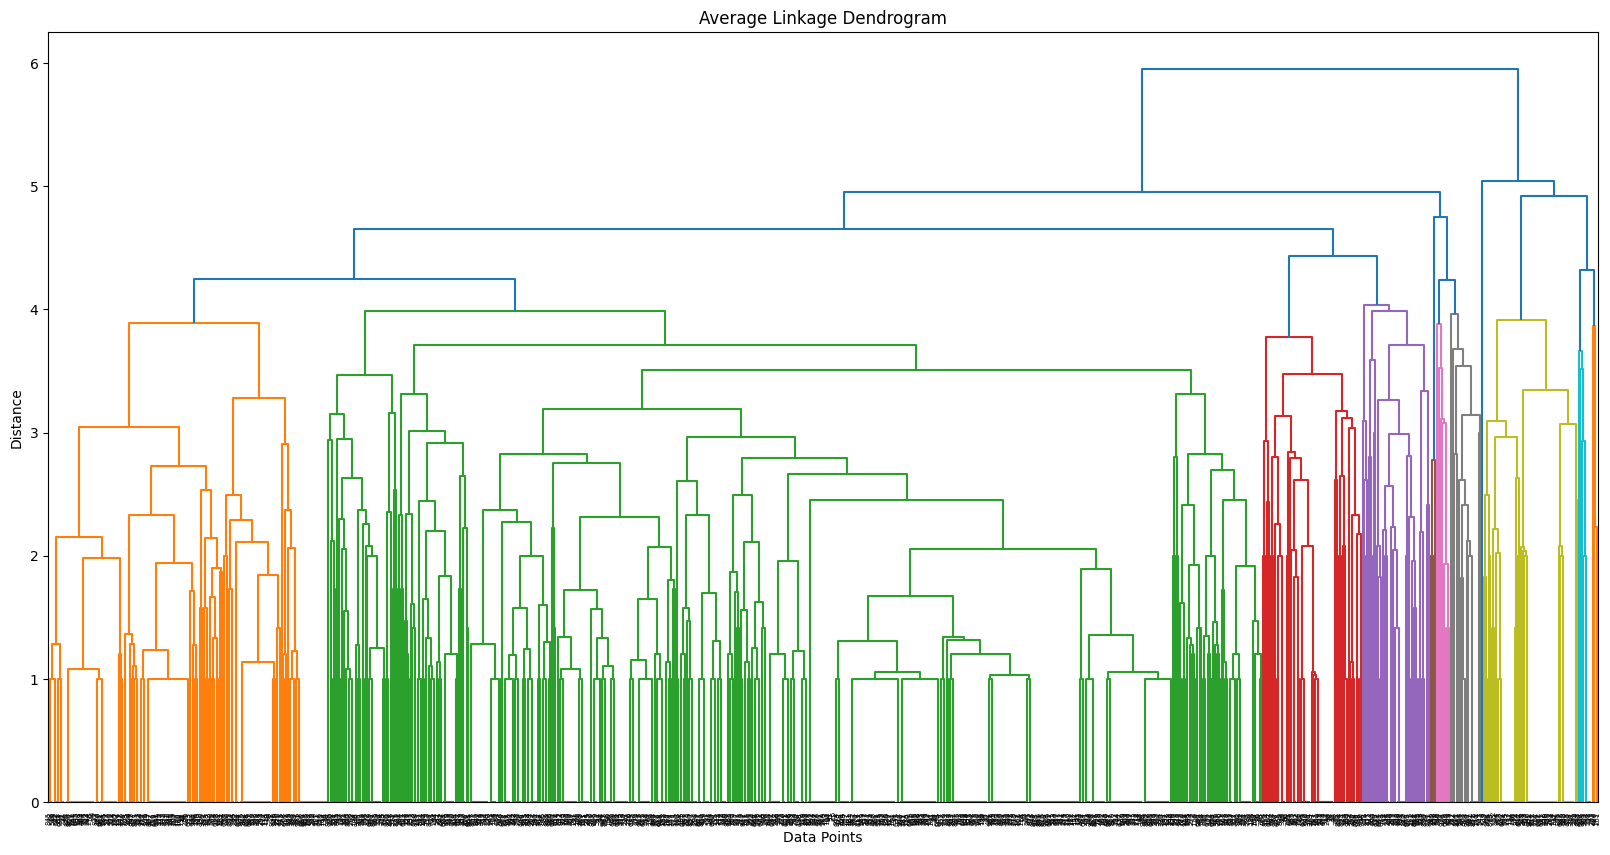

In [14]:
# Linkage matrix
avg_linkage_matrix = linkage(gpt35_padded, method='average')  # You can use other linkage methods if needed

# Visualize
plt.figure(figsize=(20, 10))
dendrogram(avg_linkage_matrix)
plt.title('Average Linkage Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


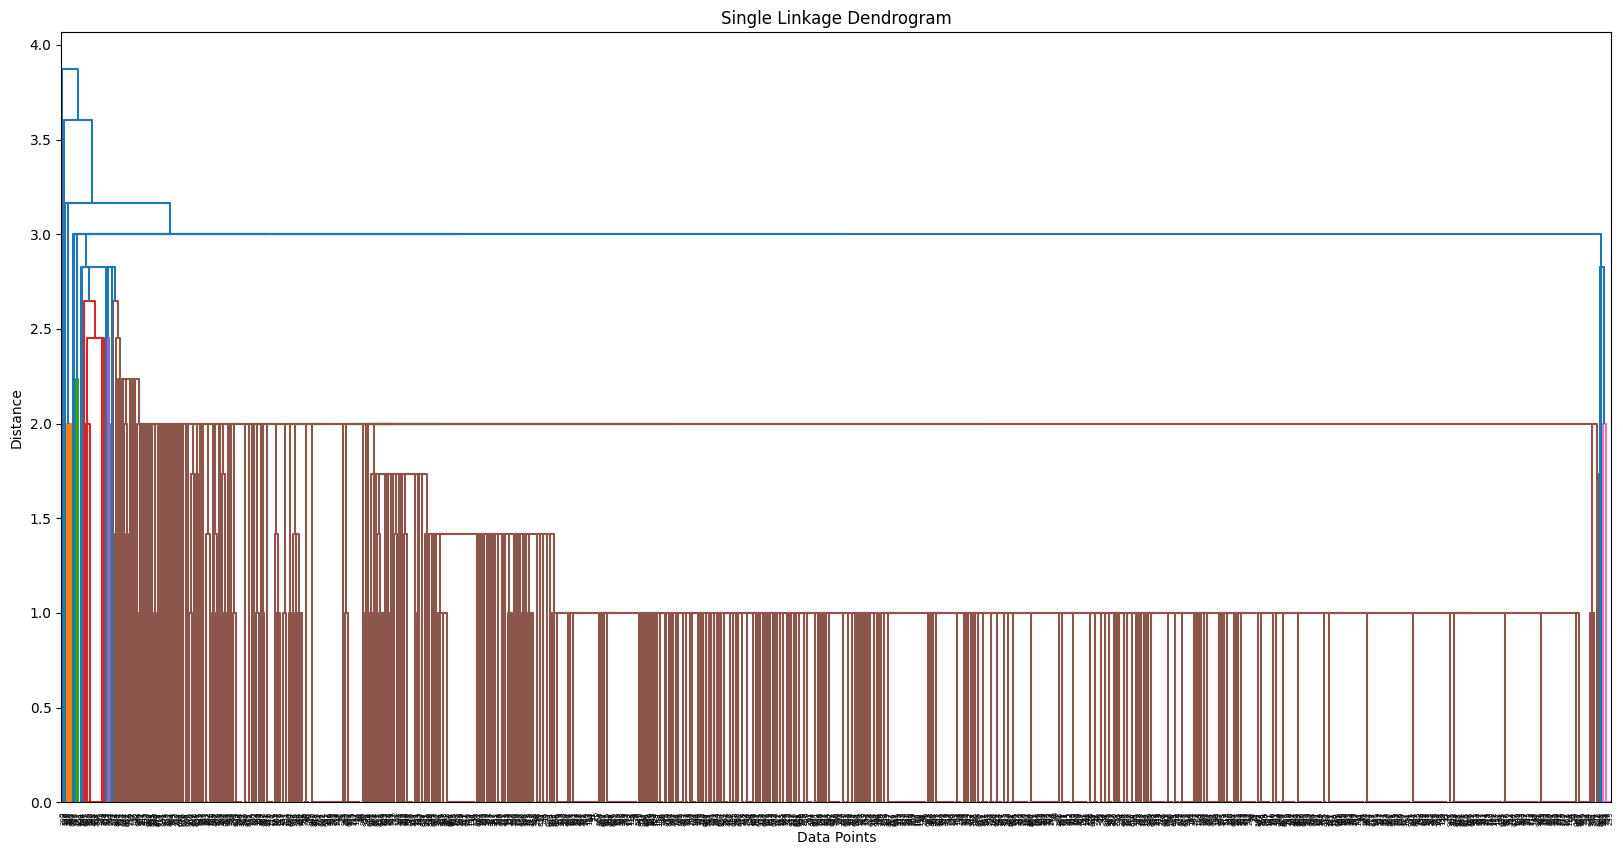

In [15]:
# Linkage matrix
single_linkage_matrix = linkage(gpt35_padded, method='single')  # You can use other linkage methods if needed

# Visualize
plt.figure(figsize=(20, 10))
dendrogram(single_linkage_matrix)
plt.title('Single Linkage Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


In [16]:
# Cluster sizes
gpt35_avg_counter = Counter(vect_label_dict[1])
gpt35_single_counter = Counter(vect_label_dict[2])
print(f'Average linkage: {gpt35_avg_counter} | Single linkage: {gpt35_single_counter}')

Average linkage: Counter({0: 980, 1: 18}) | Single linkage: Counter({0: 980, 1: 18})


Based upon the metrics and inspection of the dendrograms, it would appear single linkage with Jaccard distance produces the best results.

## GPT 4 Agglomerative Clustering Experiment

In [17]:
# Label details
gpt4vect_label_dict = defaultdict(np.array)

# Attribute details
gpt4attr_df = pd.DataFrame(data={'run_id': [np.nan]*len(agg_clust_linkages), 
                                 'linkage': [np.nan]*len(agg_clust_linkages), 
                                 'n_clusters': [np.nan]*len(agg_clust_linkages), 
                                 'n_leaves': [np.nan]*len(agg_clust_linkages), 
                                 'n_connected_components': [np.nan]*len(agg_clust_linkages),
                                 'davies_bouldin': [np.nan]*len(agg_clust_linkages),
                                 'calinski_harabasz': [np.nan]*len(agg_clust_linkages),
                                 'silhouette_score': [np.nan]*len(agg_clust_linkages)})


# Iterate through linkages
for i,link in enumerate(agg_clust_linkages):
    print(f'Begin run {i}, linkage: {link}\n\n')
    # Initialize AgglomerativeClustering
    vect_clustering = AgglomerativeClustering(metric='jaccard', linkage=link)

    # labels
    vect_labels = vect_clustering.fit_predict(gpt4_padded)
    gpt4vect_label_dict[i] = vect_labels
    
    # Davies-Bouldin score
    davies_bouldin = davies_bouldin_score(gpt4_padded, vect_labels)
    
    # Calinski-Harabasz score
    calinski_harabasz = calinski_harabasz_score(gpt4_padded, vect_labels)
    
    # Silhouette score
    silhouette = silhouette_score(gpt4_padded, vect_labels, metric='jaccard', random_state=0)
    
    # attributes
    with pd.option_context('mode.chained_assignment', None):
        gpt4attr_df.run_id[i] = i
        gpt4attr_df.linkage[i] = link
        gpt4attr_df.n_clusters[i] = vect_clustering.n_clusters_
        gpt4attr_df.n_leaves[i] = vect_clustering.n_leaves_
        gpt4attr_df.n_connected_components[i] = vect_clustering.n_connected_components_
        gpt4attr_df.davies_bouldin[i] = davies_bouldin
        gpt4attr_df.calinski_harabasz[i] = calinski_harabasz
        gpt4attr_df.silhouette_score[i] = silhouette
    
    print(f'ATTRIBUTES:')
    print(f'Davies-Bouldin score: {davies_bouldin}')
    print(f'Calinski-Harabasz score: {calinski_harabasz}')
    print(f'Silhouette score: {silhouette}')
    print(f'Cluster count: {vect_clustering.n_clusters_}')
    print(f'Number of leaves: {vect_clustering.n_leaves_}')
    print(f'Connected components: {vect_clustering.n_connected_components_}')
    print('------------------------------------------')

Begin run 0, linkage: complete


ATTRIBUTES:
Davies-Bouldin score: 3.052573382465076
Calinski-Harabasz score: 54.51693313992911
Silhouette score: -0.05738124516889553
Cluster count: 2
Number of leaves: 998
Connected components: 1
------------------------------------------
Begin run 1, linkage: average




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


ATTRIBUTES:
Davies-Bouldin score: 0.738232662384146
Calinski-Harabasz score: 30.057349103593406
Silhouette score: 0.680137882564186
Cluster count: 2
Number of leaves: 998
Connected components: 1
------------------------------------------
Begin run 2, linkage: single


ATTRIBUTES:
Davies-Bouldin score: 0.738232662384146
Calinski-Harabasz score: 30.057349103593406
Silhouette score: 0.680137882564186
Cluster count: 2
Number of leaves: 998
Connected components: 1
------------------------------------------


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


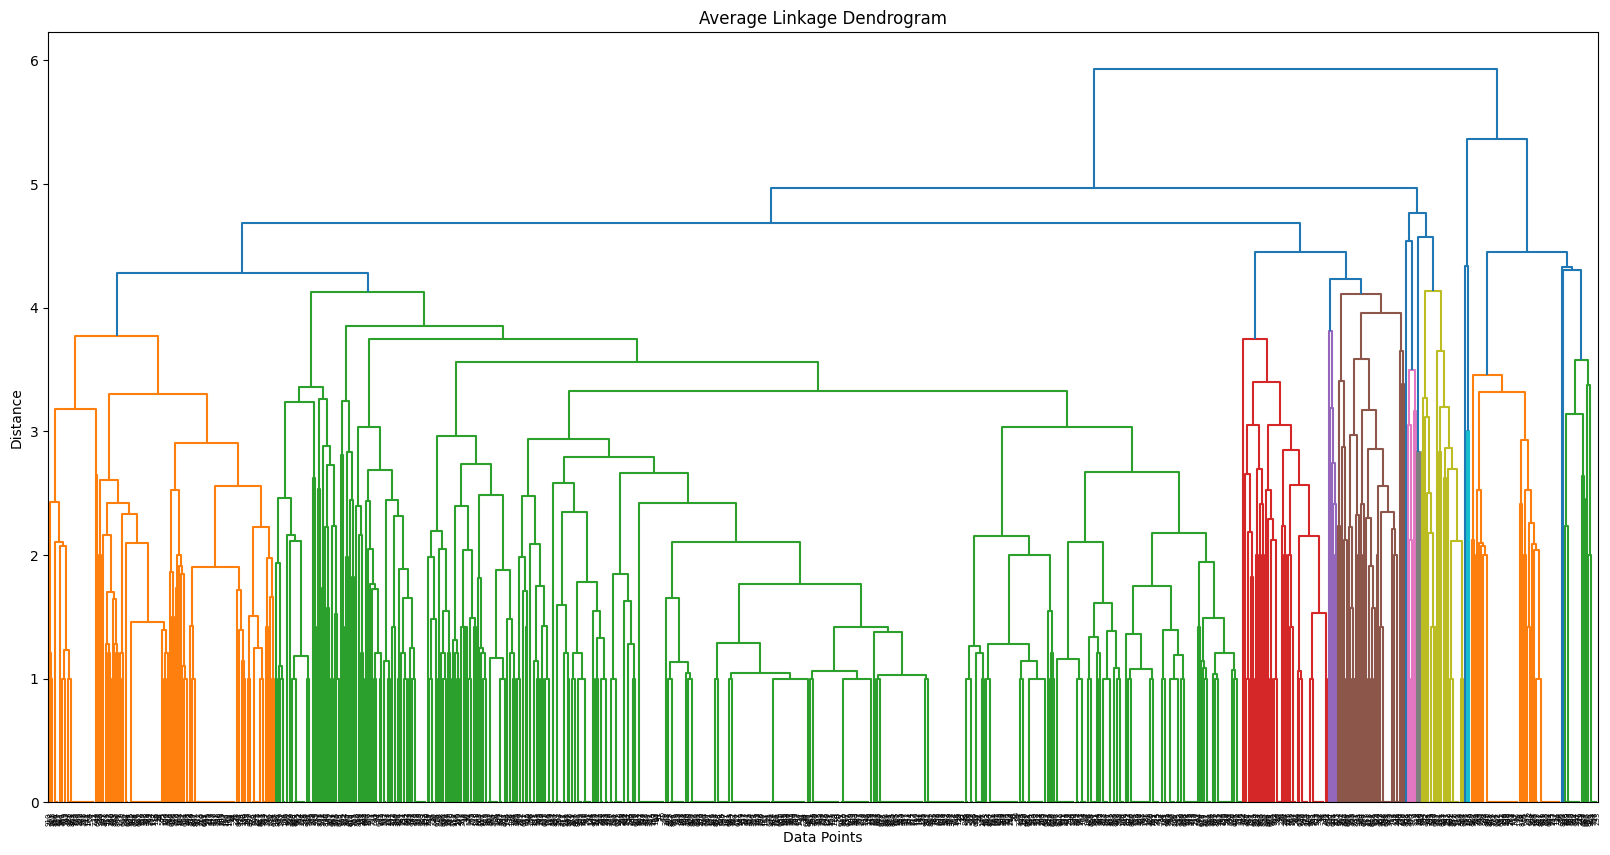

In [18]:
# Linkage matrix
gpt4avg_linkage_matrix = linkage(gpt4_padded, method='average')  # You can use other linkage methods if needed

# Visualize
plt.figure(figsize=(20, 10))
dendrogram(gpt4avg_linkage_matrix)
plt.title('Average Linkage Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


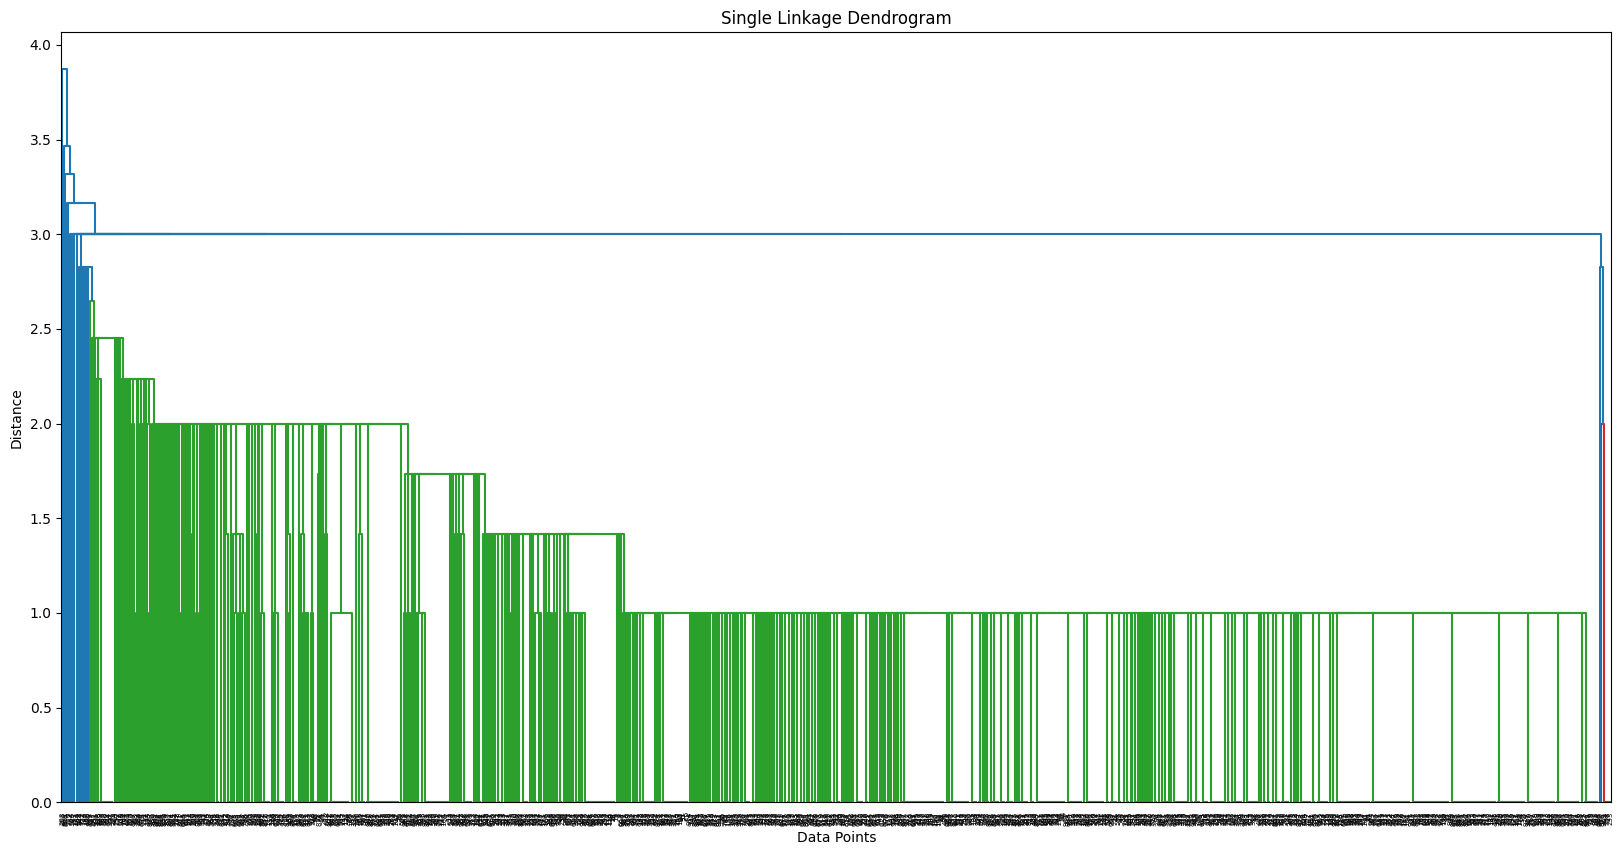

In [19]:
# Linkage matrix
gpt4single_linkage_matrix = linkage(gpt4_padded, method='single')  # You can use other linkage methods if needed

# Visualize
plt.figure(figsize=(20, 10))
dendrogram(gpt4single_linkage_matrix)
plt.title('Single Linkage Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


In [20]:
# Cluster sizes
gpt4_avg_counter = Counter(gpt4vect_label_dict[1])
gpt4_single_counter = Counter(gpt4vect_label_dict[2])
print(f'Average linkage: {gpt4_avg_counter} | Single linkage: {gpt4_single_counter}')

Average linkage: Counter({0: 980, 1: 18}) | Single linkage: Counter({0: 980, 1: 18})


## Final Interpretation

It appears that both the GPT 3.5 and GPT 4 veracity vectors clustered together similarly despite the differences in maximum vector length. At this point based on the identified fact content alone, it's not possible to say one model performs better than the other. However, this is a smaller data set. With more data points differences may emerge.